"""indicate todo's with ###"""

todo: include dev set
todo: check wheter data split is reasonable

In [1]:
import rubrix as rb
import modAL
import sklearn
import pandas as pd
from typing import List


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/jose/backends/cryptography_backend.py:18: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes, int_to_bytes


## 1) get the data
- initial_train: labeled test set ('seed')
- pool: pool of unlabeled data
- test: small labeled test set

towardsdatascience AL tutorial
https://colab.research.google.com/drive/1G_4o-1_CkR4eNgzGVcx89IJ_lKLBQQv-?usp=sharing#scrollTo=zzfQjODjFwDs

In [2]:
# 1) (index), text, label
initial_train = pd.read_csv('/Users/Maxine/Desktop/se_corpus/ud/es_data/es_ancora-ud-train.txt', sep='\t', names=['text', 'tokenized_text', 'se_label']) # macbook
# initial_train = pd.read_csv('/Users/maxine/Documents/GitHub/se_corpus/ud/es_data/es_ancora-ud-train.txt', sep='\t', names=['text', 'tokenized_text', 'se_label']) #imac
initial_train.drop(columns=['text'], inplace = True)

test = pd.read_csv('/Users/Maxine/Desktop/se_corpus/ud/es_data/es_ancora-ud-test.txt', sep='\t',names=['text', 'tokenized_text', 'se_label']) # macbook
# test = pd.read_csv('/Users/maxine/Documents/GitHub/se_corpus/ud/es_data/es_ancora-ud-test.txt', sep='\t',names=['text', 'tokenized_text', 'se_label']) # imac
test.drop(columns=['text'], inplace = True)

pool = pd.read_csv('/Users/Maxine/Desktop/se_corpus/corpusdata_org/sp_text_se_corpus.txt', names=['text'], sep='\t') # 1 col data containing comma values # macbook
# pool = pd.read_csv('/Users/maxine/Documents/GitHub/se_corpus/corpusdata_org/sp_text_se_corpus.txt', names=['text'], sep='\t') # 1 col data containing comma values # imac

# Note: for some reason jupyter cannot find the relative path

In [3]:
initial_train.shape, test.shape, pool.shape

((3453, 2), (386, 2), (12579, 1))

### 1.1) create balanced train set
- drop noisy labels from universal dependencies
- apply random oversampling

[Text(0, 0, 'expl:pv'),
 Text(1, 0, 'expl:pass'),
 Text(2, 0, 'obj'),
 Text(3, 0, 'expl:impers'),
 Text(4, 0, 'iobj'),
 Text(5, 0, 'flat'),
 Text(6, 0, 'fixed')]

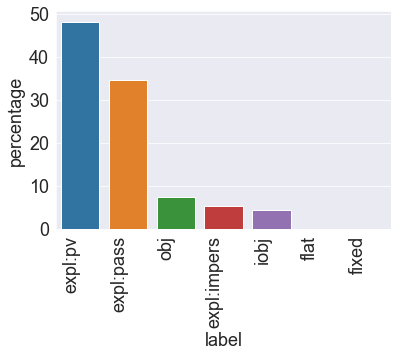

In [4]:
import matplotlib as plt
import seaborn as sns
label_counts_train = (initial_train['se_label']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .rename(columns = {"index":"label"})
                     )

label_counts_test= (test['se_label']
                     .value_counts(normalize=True)
                     .rename('percentage')
                     .mul(100)
                     .reset_index()
                     .rename(columns = {"index":"label"})
                     )

BIGGER_SIZE: int = 18
# plt.figure(figsize=(8,8))
plt.rc('font', size=BIGGER_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title=
plt.rc('axes', labelsize=BIGGER_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=BIGGER_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)

sns.set_style("darkgrid")

p_train = sns.barplot(x="label", y="percentage", data=label_counts_train)
p_train.set_xticklabels(p_train.get_xticklabels(),
                          rotation=90,
                          horizontalalignment='right')


[Text(0, 0, 'expl:pv'),
 Text(1, 0, 'expl:pass'),
 Text(2, 0, 'obj'),
 Text(3, 0, 'expl:impers'),
 Text(4, 0, 'iobj')]

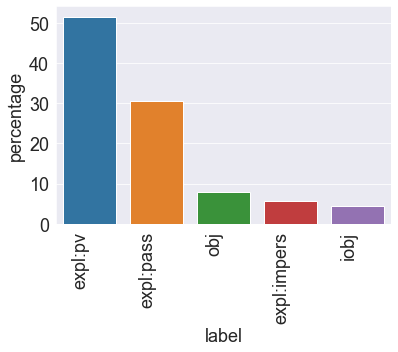

In [5]:
p_test = sns.barplot(x="label", y="percentage", data=label_counts_test)
p_test.set_xticklabels(p_test.get_xticklabels(),
                          rotation=90,
                          horizontalalignment='right')

In [ ]:
# eventually save the plots
# plt.savefig('filename.png')
# plt.show()

In [6]:
# drop labels that appear only once
initial_train = initial_train.drop(initial_train[(initial_train['se_label'] == 'flat')].index)
initial_train = initial_train.drop(initial_train[(initial_train['se_label'] == 'fixed')].index)

In [7]:
def get_balanced_set(df):
    max_size = df['se_label'].value_counts().max()
    balanced_list = [df]
    for class_index, group in df.groupby('se_label'):
        balanced_list.append(group.sample(max_size-len(group), replace=True))
    return pd.concat(balanced_list)

In [8]:
balanced_train = get_balanced_set(initial_train)

# check new label distribution
balanced_train.se_label.value_counts()

expl:pass      1663
expl:pv        1663
iobj           1663
obj            1663
expl:impers    1663
Name: se_label, dtype: int64

In [10]:
balanced_test = get_balanced_set(test)
balanced_test.se_label.value_counts()

expl:pass      199
iobj           199
expl:impers    199
expl:pv        199
obj            199
Name: se_label, dtype: int64

## 2) prepare data
- encode strings with sklearn Countvectorizer
- or apply fasttext embeddings
- encode string labels as numerical labels


sklearn: https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html
fasttext & sklearn: https://ai.intelligentonlinetools.com/ml/fasttext-word-embeddings-text-classification-python-mlp/
Keras AL tutorial: https://keras.io/examples/nlp/active_learning_review_classification/?utm_source=pocket_mylist
for torch nn.model : https://towardsdatascience.com/deep-learning-for-nlp-with-pytorch-and-torchtext-4f92d69052f

In [ ]:
# import fasttext.util
# fasttext.util.download_model('en', if_exists='ignore')  # todo change to es
# ft = fasttext.load_model('cc.en.300.bin') # rename model

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

### todo decide whether the vectorizer has to be fitted on the whole dataset
X_train = vectorizer.fit_transform(initial_train.tokenized_text)
X_balanced_train = vectorizer.transform(balanced_train.tokenized_text)
X_test = vectorizer.transform(test.tokenized_text)
X_balanced_test = vectorizer.transform(balanced_test.tokenized_text)
X_pool = vectorizer.transform(pool.text)


In [12]:
from sklearn import  preprocessing

label_encoder = preprocessing.LabelEncoder()

y_train = label_encoder.fit_transform(initial_train.se_label)
y_balanced_train = label_encoder.transform(balanced_train.se_label)
y_test = label_encoder.transform(test.se_label)
y_balanced_test = label_encoder.transform(balanced_test.se_label)

In [13]:
# check assigned values
print(list(label_encoder.classes_), label_encoder.transform(['expl:impers', 'expl:pass', 'expl:pv', 'iobj', 'obj']))


['expl:impers', 'expl:pass', 'expl:pv', 'iobj', 'obj'] [0 1 2 3 4]


## 3) train an initial model
- check accuracy values of different classifiers
- check performance of class_weight= ‘balanced’
- compare performance on train and balanced train


In [64]:
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

models = [
    LinearSVC(multi_class='ovr'),
    LinearSVC(multi_class='ovr', class_weight='balanced'),
    LogisticRegression(max_iter=1000),
    LogisticRegression(max_iter=1000, class_weight='balanced'),
    MultinomialNB(fit_prior=True),
]

cross_val = 10

df_cross_val = pd.DataFrame(index=range(cross_val * len(models)))
performances = []

for model in models:
    parameters = model.get_params()
    if 'class_weight' in parameters.keys():
        if parameters['class_weight'] == 'balanced':
            model_name = model.__class__.__name__ + '_balanced'
        else:
            model_name = model.__class__.__name__
    else:
        model_name = model.__class__.__name__
    f1_scores = cross_val_score(model,X_train, y_train, scoring='f1_weighted',cv=cross_val)
    for fold_index, f1_score in enumerate(f1_scores):
        performances.append((model_name, fold_index, f1_score))

df_cross_val = pd.DataFrame(performances, columns=['model', 'fold_index', 'f1_score_weighted'])
print(df_cross_val.groupby('model').f1_score_weighted.mean())

model
LinearSVC                      0.488250
LinearSVC_balanced             0.487004
LogisticRegression             0.482708
LogisticRegression_balanced    0.490563
MultinomialNB                  0.469553
Name: f1_score_weighted, dtype: float64


Output:

LogisticRegression_balanced gets highest f1-score.

model
LinearSVC                      0.488250
LinearSVC_balanced             0.487004
LogisticRegression             0.482708
LogisticRegression_balanced    0.490563
MultinomialNB                  0.469553
Name: f1_score_weighted, dtype: float64

check whether accuracy improves when we use over-sampled data

In [65]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report

targets = label_encoder.classes_

clf = LogisticRegression(max_iter=1000, class_weight='balanced')

# 1) oversampled training data
clf.fit(X_balanced_train, y_balanced_train)

y_pred_test = clf.predict(X_test)
print(classification_report(y_test, y_pred_test, target_names=targets, zero_division=0))

              precision    recall  f1-score   support

 expl:impers       0.90      0.41      0.56        22
   expl:pass       0.48      0.49      0.49       118
     expl:pv       0.62      0.74      0.68       199
        iobj       0.00      0.00      0.00        17
         obj       0.42      0.17      0.24        30

    accuracy                           0.57       386
   macro avg       0.48      0.36      0.39       386
weighted avg       0.55      0.57      0.55       386



best model setting:
LogisticRegression(class_weight='balanced')
with balanced/oversampled training set
and inital test set

In [66]:
from modAL.models import ActiveLearner
from modAL.uncertainty import uncertainty_sampling
import rubrix as rb

learner = ActiveLearner(estimator=LogisticRegression(max_iter=10000),
                        query_strategy=uncertainty_sampling,
                        X_training=X_balanced_train, y_training=y_balanced_train
                        )

In [73]:
# Number of instances we want to annotate per iteration
n_instances = 10

# Accuracies after each iteration to keep track of our improvement
accuracies = []

active learning loop that
- stops after 20 iterations
- opens the rubrix web interface
- waits for user response

Problem: if annotation is None (e.g in the case a sentence is discarded) the loop breaks. We have to discard certain sentences because when creating the underlying corpus
phrases that do not contain 'se' like 'aunque a tu mac no le pase nada' were not discarded because there is no programmatical way to differentiate btw. 'pase' and 'sientese'.

In [76]:
# put rubrix interaction into while loop
# while max(accuracies) < 90: # feasible?
import webbrowser

# while len(accuracies) < 20: # means we do 20 iters where we annotate 10 examples: 200 annotated sentences
while len(accuracies) < 20:
    query_idx, query_inst = learner.query(X_pool, n_instances=n_instances)
    probabilities = learner.predict_proba(X_pool[query_idx])
    records = [
    rb.TextClassificationRecord(
        id=idx,
        inputs=pool.text.iloc[idx], # not CONTENT as in docs
        # prediction=list(zip(["HAM", "SPAM"], probs)),
        prediction=list(zip(['expl:pass', 'obj', 'expl:impers', 'iobj', 'expl:pv'], probs)),
        prediction_agent="LogisticRegression", # purpose: keep track of 'who' did predictions
    )
    for idx, probs in zip(query_idx, probabilities)
]

    # Log the records
    rb.log(records, name="active_learning_se_corpus")
    webbrowser.get('firefox').open_new_tab('http://0.0.0.0:6900')

    input('confirm')
    records_df = rb.load("active_learning_se_corpus", ids=query_idx.tolist(), as_pandas=False)
    annotation = [record.annotation for record in records_df]
    if 'None' in annotation: # make it possible to discard sentences that should not be in the corpus
        print('you either discarded samples or did not annotate all of them')
        annotation = list(filter(('None').__ne__, annotation))

        # train the classifier with the newly annotated examples
    y_pool = annotation
    y_pool = label_encoder.transform(y_pool)

    learner.teach(query_inst, y_pool)

        # # Keep track of our improvement
    accuracies.append(learner.score(X=X_test, y=y_test))



  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/active_learning_se_corpus


  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/active_learning_se_corpus


  0%|          | 0/10 [00:00<?, ?it/s]

10 records logged to http://localhost:6900/ws/rubrix/active_learning_se_corpus


ValueError: y contains previously unseen labels: None

In [2]:
print(accuracies)


NameError: name 'accuracies' is not defined

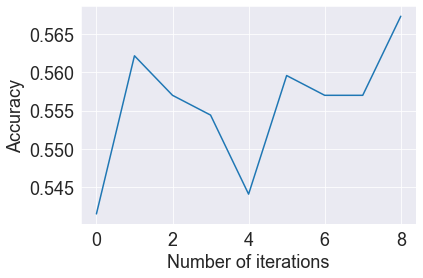

In [71]:
import matplotlib.pyplot as plt

# Plot the accuracy versus the iteration number
plt.plot(accuracies)
plt.xlabel("Number of iterations")
plt.ylabel("Accuracy");

In [ ]:
### remove queried instances from pool
    X_pool = np.delete(X_pool, query_idx, axis=0)
    y_pool = np.delete(y_pool, query_idx, axis=0)